# DEEP EUTECTIC SOLVENTS. DENSITY. Descriptors

## 1. Чтение данных

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import re
!pip install pubchempy
import pubchempy as pcp
# Импорт необходимых библиотек
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Descriptors3D
from rdkit.Chem import rdchem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.rdchem import PeriodicTable, GetPeriodicTable
from rdkit.Chem import Fragments
from rdkit.Chem.rdchem import EditableMol

In [2]:
colors = ['#41395e','#fefa9a', '#ecc2d3', '#ba8fb3', '#fffde1'] # Палетка цветов
density_df = pd.read_excel('density_without_rep.xlsx') #Чтение базы данных без повторений
density_df.head()

,Unnamed: 0.1,Unnamed: 0,Number of components,Type of DES,I,II,III,IV,V,Component#1,...,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3
0,0,0,2,Ⅰ,1,0,0,0,0,zinc chloride,...,NaN,0.5,0.5,NaN,300.2,1.10250,10.1016/j.cclet.2013.09.004,Cl[Zn]Cl,CCCCN1C=C[N+](=C1)C.[Cl-],NaN
1,1,1,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,...,NaN,0.5,0.5,NaN,313.2,1.16822,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=NC=NN1,NaN
2,2,2,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,...,NaN,0.5,0.5,NaN,313.2,1.46660,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=CC2=NNN=C2C=C1,NaN
3,3,3,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,...,NaN,0.5,0.5,NaN,313.2,1.16062,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=NNN=N1,NaN
4,4,4,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,...,NaN,0.5,0.5,NaN,313.2,1.19850,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=CC=C2C(=C1)NC=N2,NaN


## 2. Добавление дескрипторов из RDKit
По результатам литературного обзора было выяснено, что плотность может зависеть от геометричсекой формы молекулы и количества определенных групп в молекуле, поэтому данные дескрипторы были добавлены из RDKit

In [3]:
# Подгружаем базу данных индивидуальных компонентов
ind_comp_df = pd.read_excel('individual_compounds_df_new_names.xlsx')

### 2.1. Молекулярная масса
Одна из важнейших характеристик любой молекулы - молекулярная масса была добавлена для кадого индивидуального компонента

In [4]:
# Добавление строчки с молекулярной массой веществ
f_get_MW = lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x))
ind_comp_df['Molecular weight'] = ind_comp_df['CanonicalSMILES'].apply(f_get_MW)

### 2.2. 3D Дескрипторы
За форму молекулы отвечают 3D дескрипторы Asphericity, Eccentricity, InertialShapeFactor, RadiusOfGyration, SpherocityIndex

Также были добавлены моменты инерции молекул для дальнейшего получения 3D дескрипторов для смесей

In [5]:
#Asphericity
def f_get_Asphericity(smiles):
  mol_h = Chem.AddHs(Chem.MolFromSmiles(smiles)) #Получение молекулы с обозначенными Н
  ps = AllChem.EmbedParameters() 
  ps.embedFragmentsSeparately = False
  ps.useRandomCoords = True
  flag = AllChem.EmbedMultipleConfs(mol_h, 10, ps) 
  try:
    res = Descriptors3D.Asphericity(mol_h) #Вычисление дескриптора
  except:
    return None
  return res

#Eccentricity
def f_get_Eccentricity(smiles):
  mol_h = Chem.AddHs(Chem.MolFromSmiles(smiles))
  ps = AllChem.EmbedParameters()
  ps.embedFragmentsSeparately = False
  ps.useRandomCoords = True
  flag = AllChem.EmbedMultipleConfs(mol_h, 10, ps)
  try:
    res = Descriptors3D.Eccentricity(mol_h)
  except:
    return None
  return res

#InertialShapeFactor
def f_get_InertialShapeFactor(smiles):
  mol_h = Chem.AddHs(Chem.MolFromSmiles(smiles))
  ps = AllChem.EmbedParameters()
  ps.embedFragmentsSeparately = False
  ps.useRandomCoords = True
  flag = AllChem.EmbedMultipleConfs(mol_h, 10, ps)
  try:
    res = Descriptors3D.InertialShapeFactor(mol_h)
  except:
    return None
  return res

#RadiusOfGyration
def f_get_RadiusOfGyration(smiles):
  mol_h = Chem.AddHs(Chem.MolFromSmiles(smiles))
  ps = AllChem.EmbedParameters()
  ps.embedFragmentsSeparately = False
  ps.useRandomCoords = True
  flag = AllChem.EmbedMultipleConfs(mol_h, 10, ps)
  try:
    res = Descriptors3D.RadiusOfGyration(mol_h)
  except:
    return None
  return res

#SpherocityIndex
def f_get_SpherocityIndex(smiles):
  mol_h = Chem.AddHs(Chem.MolFromSmiles(smiles))
  ps = AllChem.EmbedParameters()
  ps.embedFragmentsSeparately = False
  ps.useRandomCoords = True
  flag = AllChem.EmbedMultipleConfs(mol_h, 10, ps)
  try:
    res = Descriptors3D.SpherocityIndex(mol_h)
  except:
    return None
  return res

#Моменты инерции
#PMI1
def f_get_PMI1(smiles):
  mol_h = Chem.AddHs(Chem.MolFromSmiles(smiles))
  ps = AllChem.EmbedParameters()
  ps.embedFragmentsSeparately = False
  ps.useRandomCoords = True
  flag = AllChem.EmbedMultipleConfs(mol_h, 10, ps)
  try:
    res = Descriptors3D.PMI1(mol_h)
  except:
    return None
  return res

#PMI2
def f_get_PMI2(smiles):
  mol_h = Chem.AddHs(Chem.MolFromSmiles(smiles))
  ps = AllChem.EmbedParameters()
  ps.embedFragmentsSeparately = False
  ps.useRandomCoords = True
  flag = AllChem.EmbedMultipleConfs(mol_h, 10, ps)
  try:
    res = Descriptors3D.PMI2(mol_h)
  except:
    return None
  return res


#PMI3
def f_get_PMI3(smiles):
  mol_h = Chem.AddHs(Chem.MolFromSmiles(smiles))
  ps = AllChem.EmbedParameters()
  ps.embedFragmentsSeparately = False
  ps.useRandomCoords = True
  flag = AllChem.EmbedMultipleConfs(mol_h, 10, ps)
  try:
    res = Descriptors3D.PMI3(mol_h)
  except:
    return None
  return res


#Применение функций и добавление столбцов
ind_comp_df['Asphericity'] = ind_comp_df['IsomericSMILES'].apply(f_get_Asphericity)
ind_comp_df['Eccentricity'] = ind_comp_df['IsomericSMILES'].apply(f_get_Eccentricity)
ind_comp_df['InertialShapeFactor'] = ind_comp_df['IsomericSMILES'].apply(f_get_InertialShapeFactor)
ind_comp_df['RadiusOfGyration'] = ind_comp_df['IsomericSMILES'].apply(f_get_RadiusOfGyration)
ind_comp_df['SpherocityIndex'] = ind_comp_df['IsomericSMILES'].apply(f_get_SpherocityIndex)
ind_comp_df['PMI1'] = ind_comp_df['IsomericSMILES'].apply(f_get_PMI1)
ind_comp_df['PMI2'] = ind_comp_df['IsomericSMILES'].apply(f_get_PMI2)
ind_comp_df['PMI3'] = ind_comp_df['IsomericSMILES'].apply(f_get_PMI3)


[23:24:04] UFFTYPER: Unrecognized atom type: Zn1+2 (1)
[23:24:05] UFFTYPER: Unrecognized charge state for atom: 3
[23:24:05] UFFTYPER: Unrecognized charge state for atom: 7
[23:24:05] UFFTYPER: Unrecognized charge state for atom: 4
[23:24:06] UFFTYPER: Unrecognized charge state for atom: 1
[23:24:08] UFFTYPER: Unrecognized charge state for atom: 4
[23:24:19] UFFTYPER: Unrecognized charge state for atom: 12
[23:24:19] UFFTYPER: Unrecognized atom type: Ce+3 (12)
[23:24:19] UFFTYPER: Unrecognized charge state for atom: 4
[23:24:19] UFFTYPER: Unrecognized atom type: Nd1+3 (4)
[23:24:22] UFFTYPER: Unrecognized charge state for atom: 0
[23:24:22] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[23:24:22] UFFTYPER: Unrecognized charge state for atom: 12
[23:24:22] UFFTYPER: Unrecognized atom type: La+3 (12)
[23:24:22] UFFTYPER: Unrecognized charge state for atom: 12
[23:24:22] UFFTYPER: Unrecognized atom type: Ce+3 (12)
[23:24:22] UFFTYPER: Unrecognized charge state for atom: 12
[23:24:22] UFFTYPE

[23:26:16] UFFTYPER: Unrecognized charge state for atom: 0
[23:26:16] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[23:26:16] UFFTYPER: Unrecognized charge state for atom: 12
[23:26:16] UFFTYPER: Unrecognized atom type: La+3 (12)
[23:26:16] UFFTYPER: Unrecognized charge state for atom: 12
[23:26:16] UFFTYPER: Unrecognized atom type: Ce+3 (12)
[23:26:16] UFFTYPER: Unrecognized charge state for atom: 12
[23:26:16] UFFTYPER: Unrecognized atom type: Gd2+3 (12)
[23:26:17] UFFTYPER: Unrecognized charge state for atom: 4
[23:26:18] UFFTYPER: Unrecognized charge state for atom: 2
[23:26:18] UFFTYPER: Unrecognized atom type: Zn+2 (2)
[23:26:18] UFFTYPER: Unrecognized atom type: Mn3+2 (1)
[23:26:18] UFFTYPER: Unrecognized atom type: Co3+3 (2)
[23:26:18] UFFTYPER: Unrecognized atom type: Fe5+2 (1)
[23:26:20] UFFTYPER: Unrecognized charge state for atom: 4
[23:26:21] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[23:26:21] UFFTYPER: Unrecognized atom type: Cu6+1 (1)
[23:26:21] UFFTYPER: Unr

### 2.3. Структурные фрагменты
На свойства также могут влиять количества определенных групп в молекуле

In [6]:
# Добавление структрных фрагментов
def f_get_fragments(smile):
  mols = [Chem.MolFromSmiles(i) for i in smile] #Получение списка молекул
  calc = MoleculeDescriptors.MolecularDescriptorCalculator(x[0] for x in Descriptors._descList if re.search(r'fr_', x[0]) is not None) #Выбор дескрипторов, начинающихся с fr_
  desc_names = calc.GetDescriptorNames() #Получение имен дескрипторов
  Mol_descriptors = [] #Пустой лист для заполнения значениями дескрипторов
  for mol in mols:
    mol = Chem.AddHs(mol) #Молекула с Н
    descriptors = calc.CalcDescriptors(mol) #Расчет дескрипторов
    Mol_descriptors.append(descriptors) #Добавление дескрипторов в лист
  return Mol_descriptors, desc_names

Mol_descriptors, desc_names = f_get_fragments(ind_comp_df['IsomericSMILES']) #Получение результата функции
ind_comp_df = ind_comp_df.join(pd.DataFrame(Mol_descriptors, columns = desc_names)) #Добавление в таблицу


Кроме количества отдельных групп также необходимо посчитать количество особых атомов и связей

In [7]:
# Функция для добавления молекулярных дескрипторов
def RDKit_descriptors(smiles):
  mols = [Chem.MolFromSmiles(i) for i in smiles] #Получение списка молекул
  calc = MoleculeDescriptors.MolecularDescriptorCalculator(x[0] for x in Descriptors._descList if x[0] in ['Topological Torsions', 'HeavyAtomCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumValenceElectrons', 'RingCount']) #Выбор дескрипторов из листа_
  desc_names = calc.GetDescriptorNames() #Получение имен дескрипторов
  Mol_descriptors = [] #Пустой лист для заполнения значениями дескрипторов
  for mol in mols:
    mol = Chem.AddHs(mol) #Молекула с Н
    descriptors = calc.CalcDescriptors(mol) #Расчет дескрипторов
    Mol_descriptors.append(descriptors) #Добавление дескрипторов в лист
  return Mol_descriptors, desc_names

Mol_descriptors, desc_names = RDKit_descriptors(ind_comp_df['IsomericSMILES'])
ind_comp_df = ind_comp_df.join(pd.DataFrame(Mol_descriptors, columns = desc_names)) #Добавление в таблицу


## 3. Ван-дер-Ваальсовы радиусы и объемы
Еще одной шеометричсекой характеристикой молекулы является ее Ван-дер-Ваальсов радиус, который можно высчитать по формуле:

VvdW = ∑ all atom  contributions − 5.92NB − 14.7RA − 3.8RNR (NB is the number of bonds, RA is the number of aromatic rings, and RNA is the number of nonaromatic rings)

Для вычисления вкладов атомов пользуемся формулой объема шара V шара = 4/3 ⋅ π ⋅ R^3

Количество связей
NB = N − 1 + RA + RNA (where N is the total number of atoms)

https://doi.org/10.1021/jo034808o


In [8]:
def Get_VdWVolume(smile):
  per_table = GetPeriodicTable() #Загрузка периодической системы
  mol = Chem.MolFromSmiles(smile) #Получаем молекулу
  RA = Descriptors.NumAromaticRings(mol) #Количество ароматических колец
  RNA = Descriptors.RingCount(mol) - Descriptors.NumAromaticRings(mol) #Количество неароматических колец
  mol_h = Chem.AddHs(mol) #Молекула с учетом H
  NB = mol_h.GetNumAtoms() #Число связей в молекуле
  # Получаем листы с элементами и их количеством
  MolecularFormula = pcp.get_properties('MolecularFormula', smile, 'smiles')[0]['MolecularFormula'] #Находим молекулярную формулу из смайлс
  chars = re.findall(r'[a-zA-Z]+', MolecularFormula) #Выделяем все буквенный символы (обозначения элементов)
  nums = re.findall(r'\d+', MolecularFormula) #Выделяем все цифры (индексы)
  new_chars = [] #Для записи элементов
  new_nums = [] #Для записи индексов
  # Так как единицы не ставятся в молекулярных формулах, но их нужно учитывать выделим их
  for elem in chars:
    if (sum(i.isupper() for i in elem) >= 2): # Проверяем есть ли сочетания из нескольких элементов, об этом говорят заглавные буквы
      for i in re.sub(r'([A-Z])', r' \1', elem).split(): #Делим строку по заглавным буквам
        new_chars.append(i) #Добавляем новые значения
      for _ in range(len(re.sub(r'([A-Z])', r' \1', elem).split()) - 1):
        new_nums.append(1) #Добавляем необходимое количество единиц
      try:
        new_nums.append(int(nums[chars.index(elem)])) #Добавляем число из основного списка
      except:
        new_nums.append(1)
    elif len(chars) != len(nums):
      new_chars.append(chars[chars.index(elem)])
      try:
        new_nums.append(int(nums[chars.index(elem)]))
      except:
        new_nums.append(1)
    else:
    # В случе если нет двух больших букв просто возвращаем элемент и индекс
      new_chars.append(chars[chars.index(elem)])
      new_nums.append(int(nums[chars.index(elem)]))
  #Найдем сумму вкладов атомов
  sum_atom_contributions = 0
  for i in range(len(new_chars)):
    radius = per_table.GetRvdw(new_chars[i]) #В-д-В радиус
    sum_atom_contributions += new_nums[i] * 4 / 3 * np.pi * radius**3
  # Основная формула для расчета
  VdWVolume = sum_atom_contributions - 5.98*NB - 14.7*RA - 3.8*RNA
  return VdWVolume


In [9]:
ind_comp_df['VdWVolume, A^3'] = ind_comp_df['IsomericSMILES'].apply(Get_VdWVolume) #Применение функции к датафрейму
ind_comp_df.head(3)

,Compound,Compound.1,CanonicalSMILES,IsomericSMILES,isomer,Univers_name,Molecular weight,Asphericity,Eccentricity,InertialShapeFactor,...,fr_unbrch_alkane,fr_urea,NumValenceElectrons,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,RingCount,"VdWVolume, A^3"
0,Zinc chloride,Zinc chloride,Cl[Zn]Cl,Cl[Zn]Cl,False,zinc chloride,136.296,0.758268,0.999138,0.005100,...,0,0,16,3,0,0,3,0,0,69.710435
1,1-Butyl-3-methyl imidazolium chloride,1-Butyl-3-methyl imidazolium chloride,CCCCN1C=C[N+](=C1)C.[Cl-],CCCCN1C=C[N+](=C1)C.[Cl-],False,1-Butyl-3-methylimidazolium chloride,174.675,0.219765,0.994678,0.001539,...,0,0,64,11,1,0,3,5,1,161.773246
2,1-Ethyl-3-methylimidazolium chloride,1-Ethyl-3-methylimidazolium chloride,CCN1C=C[N+](=C1)C.[Cl-],CCN1C=C[N+](=C1)C.[Cl-],False,1-Ethyl-3-methylimidazolium chloride,146.621,0.510592,0.990041,0.002124,...,0,0,52,9,1,0,3,3,1,127.541276


## 4. Добавление дескрипторов в основную таблицу

In [10]:
# Без оверсэмплинга
density_df = density_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
density_df.head()

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3
0,2,Ⅰ,1,0,0,0,0,zinc chloride,1-Butyl-3-methylimidazolium chloride,NaN,0.5,0.5,NaN,300.2,1.10250,10.1016/j.cclet.2013.09.004,Cl[Zn]Cl,CCCCN1C=C[N+](=C1)C.[Cl-],NaN
1,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,"1,2,4-TRIAZOLE",NaN,0.5,0.5,NaN,313.2,1.16822,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=NC=NN1,NaN
2,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Benzotriazole,NaN,0.5,0.5,NaN,313.2,1.46660,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=CC2=NNN=C2C=C1,NaN
3,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Tetrazole,NaN,0.5,0.5,NaN,313.2,1.16062,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=NNN=N1,NaN
4,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,BENZIMIDAZOLE,NaN,0.5,0.5,NaN,313.2,1.19850,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=CC=C2C(=C1)NC=N2,NaN


### 4.1. Добавление индивидуальных парамтеров для каждого компонента в системе

In [11]:
ind_comp_df = ind_comp_df.drop_duplicates(['IsomericSMILES']) #Удаление дублирующихся строк из базы при их наличии
ind_comp_df.index = ind_comp_df['IsomericSMILES'] #В качестве индекса используем IsomericSMILES
Descr_list =  ['Molecular weight', 'Asphericity', 'Eccentricity',
       'InertialShapeFactor', 'RadiusOfGyration', 'SpherocityIndex',
       'NumValenceElectrons', 'HeavyAtomCount', 'NumHAcceptors', 'NumHDonors',
       'NumHeteroatoms', 'NumRotatableBonds', 'RingCount', 'VdWVolume, A^3', 'PMI1', 'PMI2', 'PMI3'] #Список дескрипторов, которые будут добавлены
for desc in Descr_list:
  f_get_desc = lambda x: ind_comp_df.loc[x][desc] if isinstance(x, str) else 0 #Функция для получения дескрипторов из таблицы по индивидуальным веществам
  #Для каждого компонента системы отдельный столбик
  for num_comp in range(3):
    name_new_column = desc + '#' + str(num_comp + 1)
    name_old_column = 'isomer_smiles' + '#' + str(num_comp + 1)
    density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)


### 4.2. Добавление усредненных параметров по трем компонентам
Для колонок Molecular weight, HeavyAtomCount, NumHAcceptors, NumHDonors, NumHeteroatoms, NumRotatableBonds, RingCount посчитаем усредненные величины по двум или трем компонентам, опираясь на их мольные доли в смеси

In [12]:
# Заменим None в колонке X#3 (molar fraction) на 0 для корректности расчетов
density_df['X#3 (molar fraction)'] = density_df['X#3 (molar fraction)'].replace(np.nan, 0)
Desc_list_new = ['Molecular weight', 'HeavyAtomCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'RingCount'] #Список дескрипторов
#Усреднение дескрипторов
for desc in Desc_list_new:
  density_df[desc] = density_df[desc + '#' + '1'] * density_df['X#1 (molar fraction)'] + density_df[desc + '#' + '2'] * density_df['X#2 (molar fraction)'] + density_df[desc + '#' + '3'] * density_df['X#3 (molar fraction)']

density_df

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,...,PMI3#1,PMI3#2,PMI3#3,Molecular weight,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,RingCount
0,2,Ⅰ,1,0,0,0,0,zinc chloride,1-Butyl-3-methylimidazolium chloride,NaN,...,290.146733,1553.245754,0.0,155.48550,7.00,0.50,0.00,3.00,2.50,0.5
1,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,"1,2,4-TRIAZOLE",NaN,...,1373.130928,98.169345,0.0,107.84400,7.00,1.50,0.50,3.00,1.50,1.0
2,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Benzotriazole,NaN,...,1373.130928,418.031565,0.0,132.87400,9.00,1.50,0.50,3.00,1.50,1.5
3,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Tetrazole,NaN,...,1373.130928,95.875740,0.0,108.33800,7.00,2.00,0.50,3.50,1.50,1.0
4,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,BENZIMIDAZOLE,NaN,...,1373.130928,415.549751,0.0,132.38000,9.00,1.00,0.50,2.50,1.50,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4161,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,NaN,...,246.133832,518.065856,0.0,116.23997,4.74,0.37,0.37,3.26,1.11,0.0
4162,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,NaN,...,246.133832,518.065856,0.0,116.23997,4.74,0.37,0.37,3.26,1.11,0.0
4163,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,NaN,...,246.133832,518.065856,0.0,116.23997,4.74,0.37,0.37,3.26,1.11,0.0
4164,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,NaN,...,246.133832,518.065856,0.0,116.23997,4.74,0.37,0.37,3.26,1.11,0.0


### 4.3. Добавление усредненных парамтеров для Asphericity, Eccentricity, InertialShapeFactor, RadiusOfGyration, SpherocityIndex

Для данных дескрипторов нельзя все усреднить только с учетом мольных долей, так как в каждой формуле для расчета встречаются моменты инерции, поэтому напишем для каждого парметра функцию, которая сможет находить значения с усредненными по мольным долям моментами инерции

In [13]:
#Asphericity
def f_get_Asphericity_gen():
  #Выражения для моментов инерции
  pm1 = density_df['PMI1#1'] * density_df['X#1 (molar fraction)'] + density_df['PMI1#2'] * density_df['X#2 (molar fraction)'] + density_df['PMI1#3'] * density_df['X#3 (molar fraction)']
  pm2 = density_df['PMI2#1'] * density_df['X#1 (molar fraction)'] + density_df['PMI2#2'] * density_df['X#2 (molar fraction)'] + density_df['PMI2#3'] * density_df['X#3 (molar fraction)']
  pm3 = density_df['PMI3#1'] * density_df['X#1 (molar fraction)'] + density_df['PMI3#2'] * density_df['X#2 (molar fraction)'] + density_df['PMI3#3'] * density_df['X#3 (molar fraction)']
  #Формула для Asphericity
  return 0.5 * ((pm3-pm2)**2 + (pm3-pm1)**2 + (pm2-pm1)**2)/(pm1**2+pm2**2+pm3**2)


#Eccentricity
def f_get_Eccentricity_gen():
  #Выражения для моментов инерции
  pm1 = density_df['PMI1#1'] * density_df['X#1 (molar fraction)'] + density_df['PMI1#2'] * density_df['X#2 (molar fraction)'] + density_df['PMI1#3'] * density_df['X#3 (molar fraction)']
  pm2 = density_df['PMI2#1'] * density_df['X#1 (molar fraction)'] + density_df['PMI2#2'] * density_df['X#2 (molar fraction)'] + density_df['PMI2#3'] * density_df['X#3 (molar fraction)']
  pm3 = density_df['PMI3#1'] * density_df['X#1 (molar fraction)'] + density_df['PMI3#2'] * density_df['X#2 (molar fraction)'] + density_df['PMI3#3'] * density_df['X#3 (molar fraction)']
  #Формула для Eccentricity
  return np.sqrt(pm3**2 -pm1**2) / pm3

#InertialShapeFactor
def f_get_InertialShapeFactor_gen():
  #Выражения для моментов инерции
  pm1 = density_df['PMI1#1'] * density_df['X#1 (molar fraction)'] + density_df['PMI1#2'] * density_df['X#2 (molar fraction)'] + density_df['PMI1#3'] * density_df['X#3 (molar fraction)']
  pm2 = density_df['PMI2#1'] * density_df['X#1 (molar fraction)'] + density_df['PMI2#2'] * density_df['X#2 (molar fraction)'] + density_df['PMI2#3'] * density_df['X#3 (molar fraction)']
  pm3 = density_df['PMI3#1'] * density_df['X#1 (molar fraction)'] + density_df['PMI3#2'] * density_df['X#2 (molar fraction)'] + density_df['PMI3#3'] * density_df['X#3 (molar fraction)']
  #Формула для InertialShapeFactor
  return pm2 / (pm1*pm3)

#RadiusOfGyration
def f_get_RadiusOfGyration_gen():
  #Выражения для моментов инерции
  pm1 = density_df['PMI1#1'] * density_df['X#1 (molar fraction)'] + density_df['PMI1#2'] * density_df['X#2 (molar fraction)'] + density_df['PMI1#3'] * density_df['X#3 (molar fraction)']
  pm2 = density_df['PMI2#1'] * density_df['X#1 (molar fraction)'] + density_df['PMI2#2'] * density_df['X#2 (molar fraction)'] + density_df['PMI2#3'] * density_df['X#3 (molar fraction)']
  pm3 = density_df['PMI3#1'] * density_df['X#1 (molar fraction)'] + density_df['PMI3#2'] * density_df['X#2 (molar fraction)'] + density_df['PMI3#3'] * density_df['X#3 (molar fraction)']
  #Формула для RadiusOfGyration
  return np.sqrt( 2*np.pi*pow(pm3*pm2*pm1,1/3)/density_df['Molecular weight'] )

#SpherocityIndex
def f_get_SpherocityIndex_gen():
  #Выражения для моментов инерции
  pm1 = density_df['PMI1#1'] * density_df['X#1 (molar fraction)'] + density_df['PMI1#2'] * density_df['X#2 (molar fraction)'] + density_df['PMI1#3'] * density_df['X#3 (molar fraction)']
  pm2 = density_df['PMI2#1'] * density_df['X#1 (molar fraction)'] + density_df['PMI2#2'] * density_df['X#2 (molar fraction)'] + density_df['PMI2#3'] * density_df['X#3 (molar fraction)']
  pm3 = density_df['PMI3#1'] * density_df['X#1 (molar fraction)'] + density_df['PMI3#2'] * density_df['X#2 (molar fraction)'] + density_df['PMI3#3'] * density_df['X#3 (molar fraction)']
  #Формула для SpherocityIndex
  return 3 * pm1 / (pm1+pm2+pm3)


density_df['Asphericity'] = f_get_Asphericity_gen()
density_df['Eccentricity'] = f_get_Eccentricity_gen()
density_df['InertialShapeFactor'] = f_get_InertialShapeFactor_gen()
density_df['RadiusOfGyration'] = f_get_RadiusOfGyration_gen()
density_df['SpherocityIndex'] = f_get_SpherocityIndex_gen()
density_df.head()

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,...,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,RingCount,Asphericity,Eccentricity,InertialShapeFactor,RadiusOfGyration,SpherocityIndex
0,2,Ⅰ,1,0,0,0,0,zinc chloride,1-Butyl-3-methylimidazolium chloride,NaN,...,0.5,0.0,3.0,2.5,0.5,0.142990,0.906908,0.002028,5.077903,0.572241
1,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,"1,2,4-TRIAZOLE",NaN,...,1.5,0.5,3.0,1.5,1.0,0.383178,0.974644,0.002717,4.460846,0.401720
2,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Benzotriazole,NaN,...,1.5,0.5,3.0,1.5,1.5,0.353764,0.974630,0.002533,4.529124,0.387775
3,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Tetrazole,NaN,...,2.0,0.5,3.5,1.5,1.0,0.384268,0.974748,0.002719,4.443641,0.401312
4,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,BENZIMIDAZOLE,NaN,...,1.0,0.5,2.5,1.5,1.5,0.350674,0.973727,0.002487,4.545670,0.393918


### 4.4. Добавление и усреднение структурных дескрипторов

In [14]:
# Добавление структурных дескрипторов в основную таблицу
Descr_list =  [x for x in ind_comp_df.columns if re.search(r'fr_', x) is not None] #Список дескрипторов
for desc in Descr_list:
  f_get_desc = lambda x: ind_comp_df.loc[x][desc] if isinstance(x, str) else 0 #Функция добавления дескриптора
  #Добавление в таблицу с оформлением названия
  for num_comp in range(3):
    name_new_column = desc + '#' + str(num_comp + 1)
    name_old_column = 'isomer_smiles' + '#' + str(num_comp + 1)
    density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)

C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[name_new_column] = density_df[name_old_column].apply(f_get_desc)
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4005198871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

In [15]:
# Посчитаем среднее по дескрипторам
density_df['X#3 (molar fraction)'] = density_df['X#3 (molar fraction)'].replace(np.nan, 0)
Desc_list_new = [x for x in ind_comp_df.columns if re.search(r'fr_', x) is not None]
for desc in Desc_list_new:
  density_df[desc] = density_df[desc + '#' + '1'] * density_df['X#1 (molar fraction)'] + density_df[desc + '#' + '2'] * density_df['X#2 (molar fraction)'] + density_df[desc + '#' + '3'] * density_df['X#3 (molar fraction)']

density_df.head()

C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\1391269445.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[desc] = density_df[desc + '#' + '1'] * density_df['X#1 (molar fraction)'] + density_df[desc + '#' + '2'] * density_df['X#2 (molar fraction)'] + density_df[desc + '#' + '3'] * density_df['X#3 (molar fraction)']
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\1391269445.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[desc] = density_df[desc + '#' + '1'] * density_df['X#1 (molar fraction)'] + 

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,2,Ⅰ,1,0,0,0,0,zinc chloride,1-Butyl-3-methylimidazolium chloride,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,"1,2,4-TRIAZOLE",NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Benzotriazole,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Tetrazole,NaN,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
4,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,BENZIMIDAZOLE,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4.5. Fingerprints
Фингерпринт — вектор чисел, описывающий структурный состав молекулы, а с появлением машинного обучения — вектор абстрактных свойств молекулы, на основе которого можно делать предсказания молекулярных свойств. 

In [16]:
#Функция для получения общего смайлс в итоговой таблице
def f_get_smiles():
  if isinstance(density_df['isomer_smiles#3'], str):
    smile = density_df['isomer_smiles#1'] + '.' + density_df['isomer_smiles#2'] + '.' + density_df['isomer_smiles#3']
  else:
    smile = density_df['isomer_smiles#1'] + '.' + density_df['isomer_smiles#2']
  return smile

#Создаем общий смайлс для системы
density_df['SMILE'] = f_get_smiles()
density_df

C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\3418944898.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df['SMILE'] = f_get_smiles()


,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,SMILE
0,2,Ⅰ,1,0,0,0,0,zinc chloride,1-Butyl-3-methylimidazolium chloride,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cl[Zn]Cl.CCCCN1C=C[N+](=C1)C.[Cl-]
1,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,"1,2,4-TRIAZOLE",NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCN1C=C[N+](=C1)C.[Cl-].C1=NC=NN1
2,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Benzotriazole,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCN1C=C[N+](=C1)C.[Cl-].C1=CC2=NNN=C2C=C1
3,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Tetrazole,NaN,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,CCN1C=C[N+](=C1)C.[Cl-].C1=NNN=N1
4,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,BENZIMIDAZOLE,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCN1C=C[N+](=C1)C.[Cl-].C1=CC=C2C(=C1)NC=N2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4161,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCCC(=O)N.[Al](Cl)(Cl)Cl
4162,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCCC(=O)N.[Al](Cl)(Cl)Cl
4163,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCCC(=O)N.[Al](Cl)(Cl)Cl
4164,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCCC(=O)N.[Al](Cl)(Cl)Cl


In [31]:
#Функция добавления фингерпринтов в основную таблицу
f_get_FingerPrints = lambda x: np.array((AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 2, nBits=256)))
FP_list = ['FP' + str(x) for x in range(256)]
density_df[FP_list] = None
for ind in density_df.index:
  FP_Comp = f_get_FingerPrints(density_df.iloc[ind]['SMILE'])
  for FP in FP_list:
    density_df.loc[ind, FP] = FP_Comp[FP_list.index(FP)]
density_df


C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\953624568.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[FP_list] = None
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\953624568.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  density_df[FP_list] = None
C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\953624568.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using 

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,...,FP246,FP247,FP248,FP249,FP250,FP251,FP252,FP253,FP254,FP255
0,2,Ⅰ,1,0,0,0,0,zinc chloride,1-Butyl-3-methylimidazolium chloride,NaN,...,0,0,0,0,0,0,0,0,0,1
1,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,"1,2,4-TRIAZOLE",NaN,...,0,0,0,0,0,0,1,0,0,0
2,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Benzotriazole,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Tetrazole,NaN,...,0,0,0,0,0,0,0,0,0,0
4,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,BENZIMIDAZOLE,NaN,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4161,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,NaN,...,0,0,0,0,0,0,0,0,0,0
4162,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,NaN,...,0,0,0,0,0,0,0,0,0,0
4163,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,NaN,...,0,0,0,0,0,0,0,0,0,0
4164,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,NaN,...,0,0,0,0,0,0,0,0,0,0


## 5. Выбор дескрипторов
Для последующего машинного обучения нужно выбрать дескрипторы, чтобы избежать переобучения необходимо, чтобы дескрипторы не коррелировали между собой, поэтому построим тепловые диграммы

### 5.1. Тепловая диаграмма для молекулярных дескрипторов

In [32]:
# Выделяем необходимые столбики
new_density_df = density_df[['Density, g/cm^3', 'Number of components', 'Type of DES', 'Component#1', 'Component#2',
       'Component#3', 'X#1 (molar fraction)', 'X#2 (molar fraction)',
       'X#3 (molar fraction)','I', 'II', 'III', 'IV', 'V', 'Temperature, K','isomer_smiles#1', 'isomer_smiles#2',
       'isomer_smiles#3', 'Asphericity',
       'Eccentricity',
       'InertialShapeFactor', 'RadiusOfGyration', 'SpherocityIndex', 'NumValenceElectrons#1', 'NumValenceElectrons#2',
       'NumValenceElectrons#3', 'VdWVolume, A^3#1',
       'VdWVolume, A^3#2', 'VdWVolume, A^3#3', 'Molecular weight',
       'HeavyAtomCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms',
       'NumRotatableBonds', 'RingCount']]

Чтобы выбрать дескрипторы для дальнейшего машинного обучения посомтрим на тепловую диаграмму, дескрипторы, у которых наблюдаются сильные корреляции с другими дескрипторами будут удалены

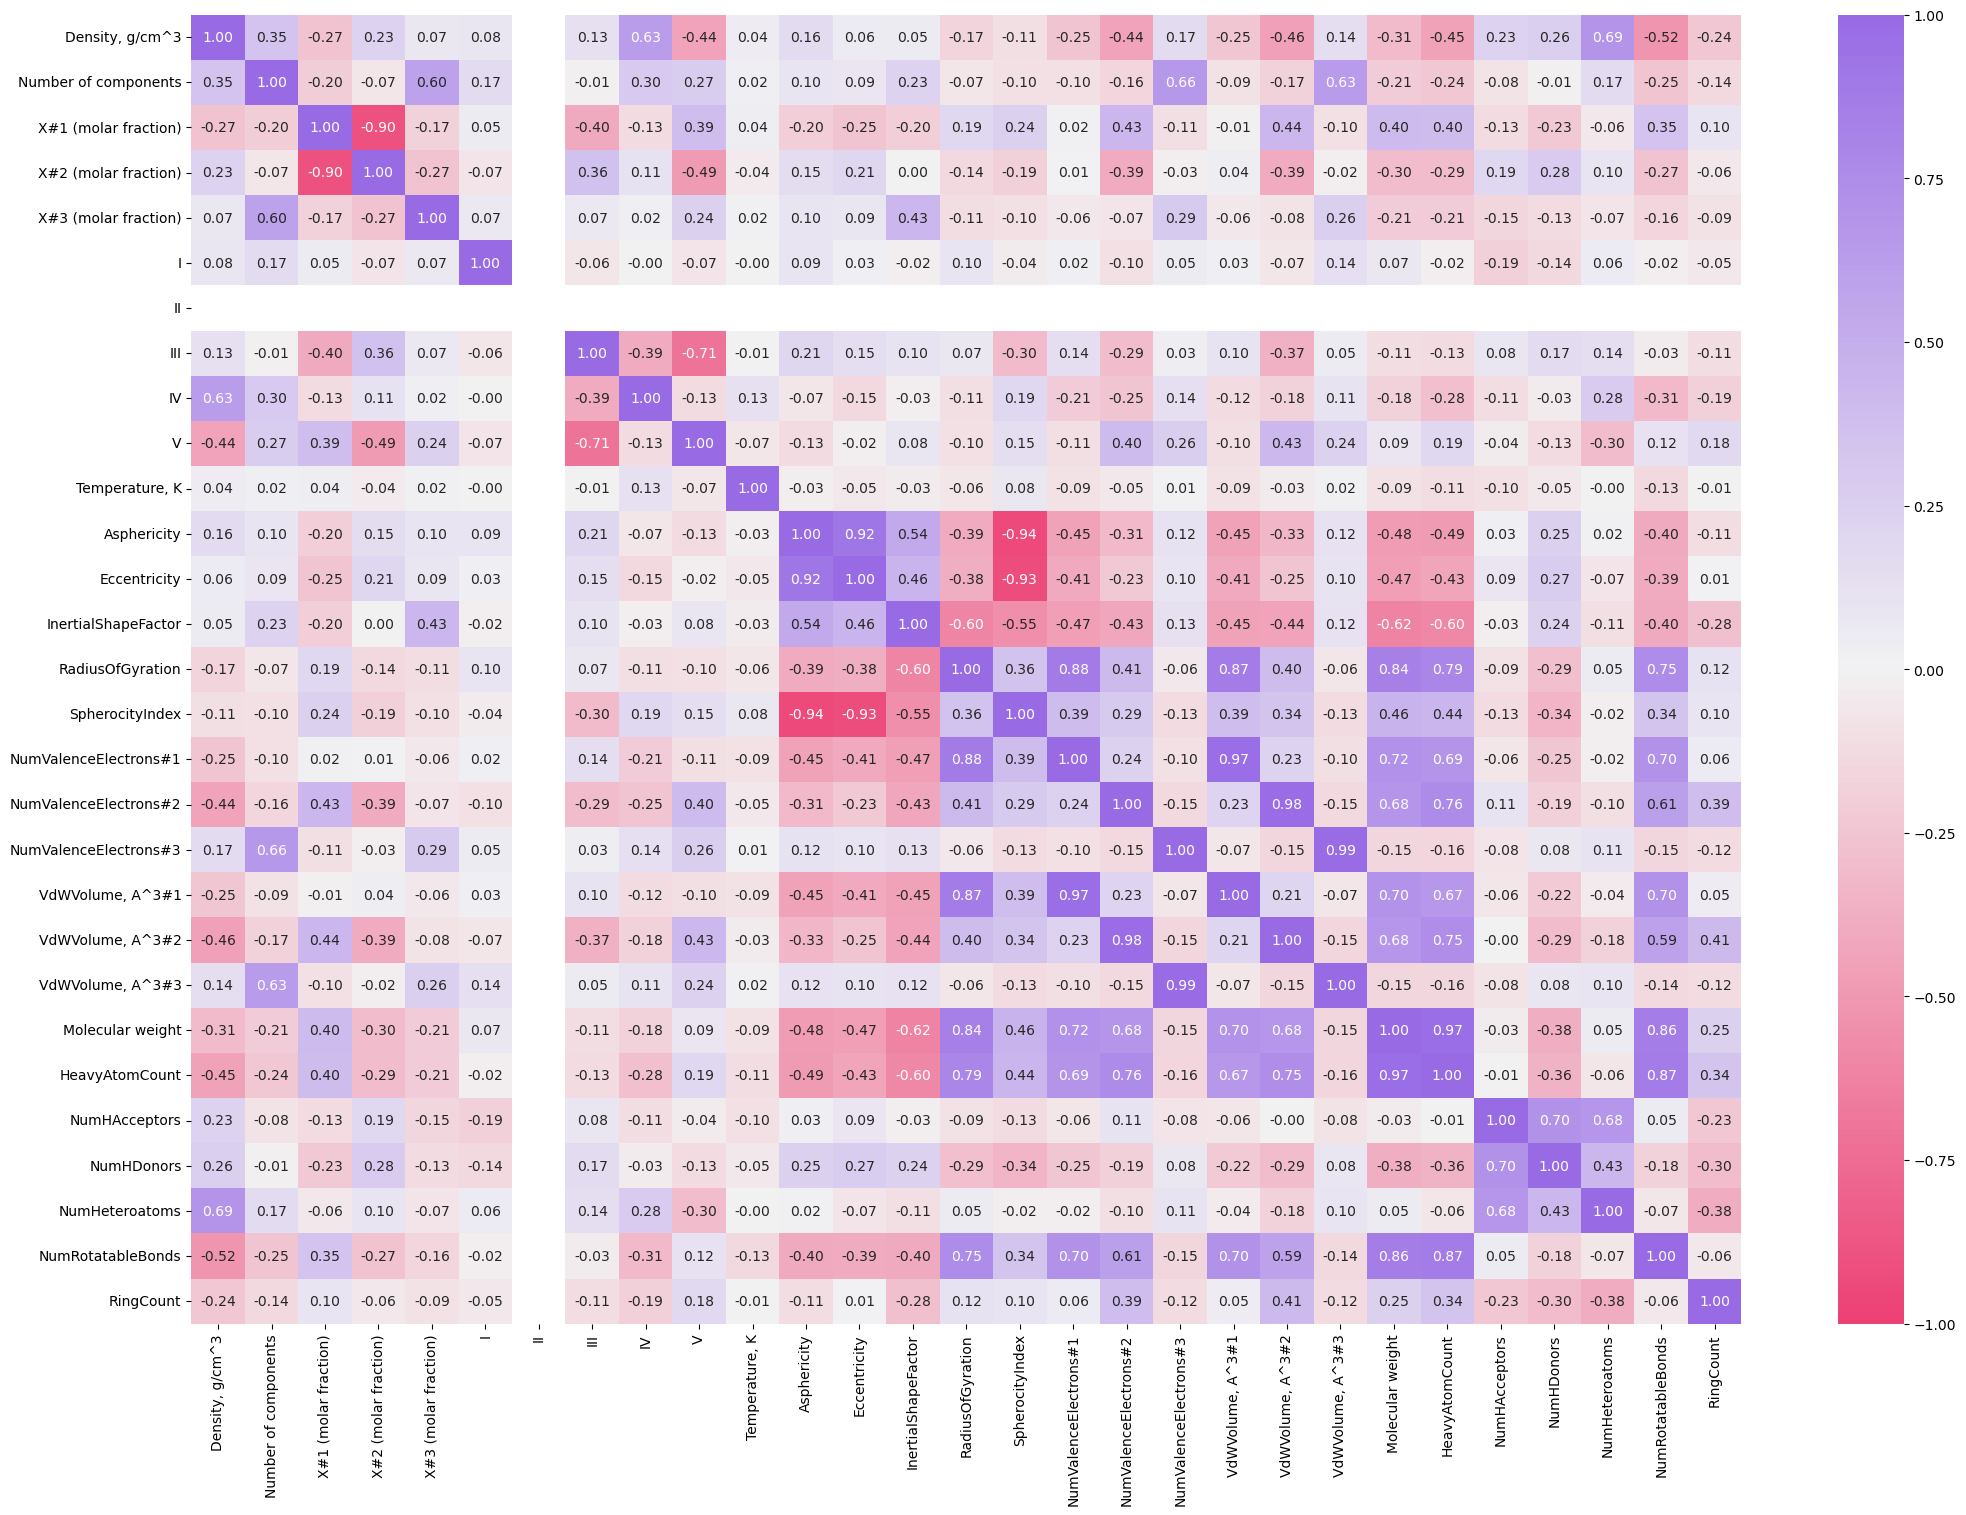

In [33]:
# Корреляции и тепловая диаграмма
#mask = np.triu(np.ones_like(new_density_df.corr(), dtype=bool)) #создаем маску для выделения верхнего треугольника массива
cmap = sns.diverging_palette(0, 277, s=80, l=55, n=9, as_cmap=True) #создание палитры для корреляционного графика
plt.figure(figsize=(25, 17)) #создание графика и определение его размеров
plot = sns.heatmap(new_density_df.corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, center= 0, cmap=cmap, linewidth=0.0005) 
#annot=True - вывод коэффициентов корреляции, fmt - число знаков после запятой, v - пределы, cmap - палитра, linewidth - толщина шрифта
plt.savefig('corr.png')

Видно, что многие параметры коррелируют с молекулярной массой, что объясняется тем, что она входит в их формулы, также коррелируют парметры, отвечающие за геометрию молекул

### 5.2. Тепловые диаграммы для структурных групп

In [34]:
Descr_list = [x for x in ind_comp_df.columns if re.search(r'fr_', x) is not None]
for fr in Descr_list:
  sum_col = ind_comp_df[fr].sum()
  if sum_col == 0:
    ind_comp_df = ind_comp_df.drop(fr, axis = 1) 

ind_comp_df

,Compound,Compound.1,CanonicalSMILES,IsomericSMILES,isomer,Univers_name,Molecular weight,Asphericity,Eccentricity,InertialShapeFactor,...,fr_thiocyan,fr_urea,NumValenceElectrons,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,RingCount,"VdWVolume, A^3"
IsomericSMILES,,,,,,,,,,,,,,,,,,,,,
Cl[Zn]Cl,Zinc chloride,Zinc chloride,Cl[Zn]Cl,Cl[Zn]Cl,False,zinc chloride,136.296,0.758268,0.999138,0.005100,...,0,0,16,3,0,0,3,0,0,69.710435
CCCCN1C=C[N+](=C1)C.[Cl-],1-Butyl-3-methyl imidazolium chloride,1-Butyl-3-methyl imidazolium chloride,CCCCN1C=C[N+](=C1)C.[Cl-],CCCCN1C=C[N+](=C1)C.[Cl-],False,1-Butyl-3-methylimidazolium chloride,174.675,0.219765,0.994678,0.001539,...,0,0,64,11,1,0,3,5,1,161.773246
CCN1C=C[N+](=C1)C.[Cl-],1-Ethyl-3-methylimidazolium chloride,1-Ethyl-3-methylimidazolium chloride,CCN1C=C[N+](=C1)C.[Cl-],CCN1C=C[N+](=C1)C.[Cl-],False,1-Ethyl-3-methylimidazolium chloride,146.621,0.510592,0.990041,0.002124,...,0,0,52,9,1,0,3,3,1,127.541276
C1=NC=NN1,"1,2,4-Triazole","1,2,4-Triazole",C1=NC=NN1,C1=NC=NN1,False,"1,2,4-TRIAZOLE",69.067,0.248222,0.879464,0.010976,...,0,0,26,5,2,1,3,0,1,51.805595
C1=CC2=NNN=C2C=C1,1H-Benzotriazole,1H-Benzotriazole,C1=CC2=NNN=C2C=C1,C1=CC2=NNN=C2C=C1,False,1H-Benzotriazole,119.127,0.385630,0.958893,0.006118,...,0,0,44,9,2,1,3,0,2,98.020159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[Al](Cl)(Cl)Cl,AlCl3,AlCl3,[Al](Cl)(Cl)Cl,[Al](Cl)(Cl)Cl,False,ALUMINUM CHLORIDE,133.341,0.249806,0.867544,0.001977,...,0,0,24,4,0,0,4,0,0,88.159460
Cl[Cu]Cl,CuCl2,CuCl2,Cl[Cu]Cl,Cl[Cu]Cl,False,CUPRIC CHLORIDE,134.452,0.695026,0.992976,1.295776,...,0,0,25,3,0,0,3,0,0,64.428371
Cl[Sn](Cl)(Cl)Cl,SnCl4,SnCl4,Cl[Sn](Cl)(Cl)Cl,Cl[Sn](Cl)(Cl)Cl,False,Tin tetrachloride,260.523,0.000050,0.233951,0.001946,...,0,0,32,5,0,0,5,0,0,115.529036


In [35]:
# Выделяем необходимые столбики
List2 =  [x for x in ind_comp_df.columns if re.search(r'fr_', x) is not None]
List1 = ['Density, g/cm^3', 'Number of components', 'Type of DES', 'Component#1', 'Component#2',
       'Component#3', 'X#1 (molar fraction)', 'X#2 (molar fraction)',
       'X#3 (molar fraction)', 'Temperature, K','isomer_smiles#1', 'isomer_smiles#2',
       'isomer_smiles#3']
Desc_list_heatmap = List1 + List2 
Desc_list_heatmap
new_density_df_str = density_df[Desc_list_heatmap]
new_density_df_str.head()

,"Density, g/cm^3",Number of components,Type of DES,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K",...,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_piperdine,fr_piperzine,fr_priamide,fr_quatN,fr_tetrazole,fr_thiocyan,fr_urea
0,1.10250,2,Ⅰ,zinc chloride,1-Butyl-3-methylimidazolium chloride,NaN,0.5,0.5,0.0,300.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.16822,2,Ⅲ,1-Ethyl-3-methylimidazolium chloride,"1,2,4-TRIAZOLE",NaN,0.5,0.5,0.0,313.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.46660,2,Ⅲ,1-Ethyl-3-methylimidazolium chloride,1H-Benzotriazole,NaN,0.5,0.5,0.0,313.2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.16062,2,Ⅲ,1-Ethyl-3-methylimidazolium chloride,1H-Tetrazole,NaN,0.5,0.5,0.0,313.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
4,1.19850,2,Ⅲ,1-Ethyl-3-methylimidazolium chloride,BENZIMIDAZOLE,NaN,0.5,0.5,0.0,313.2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


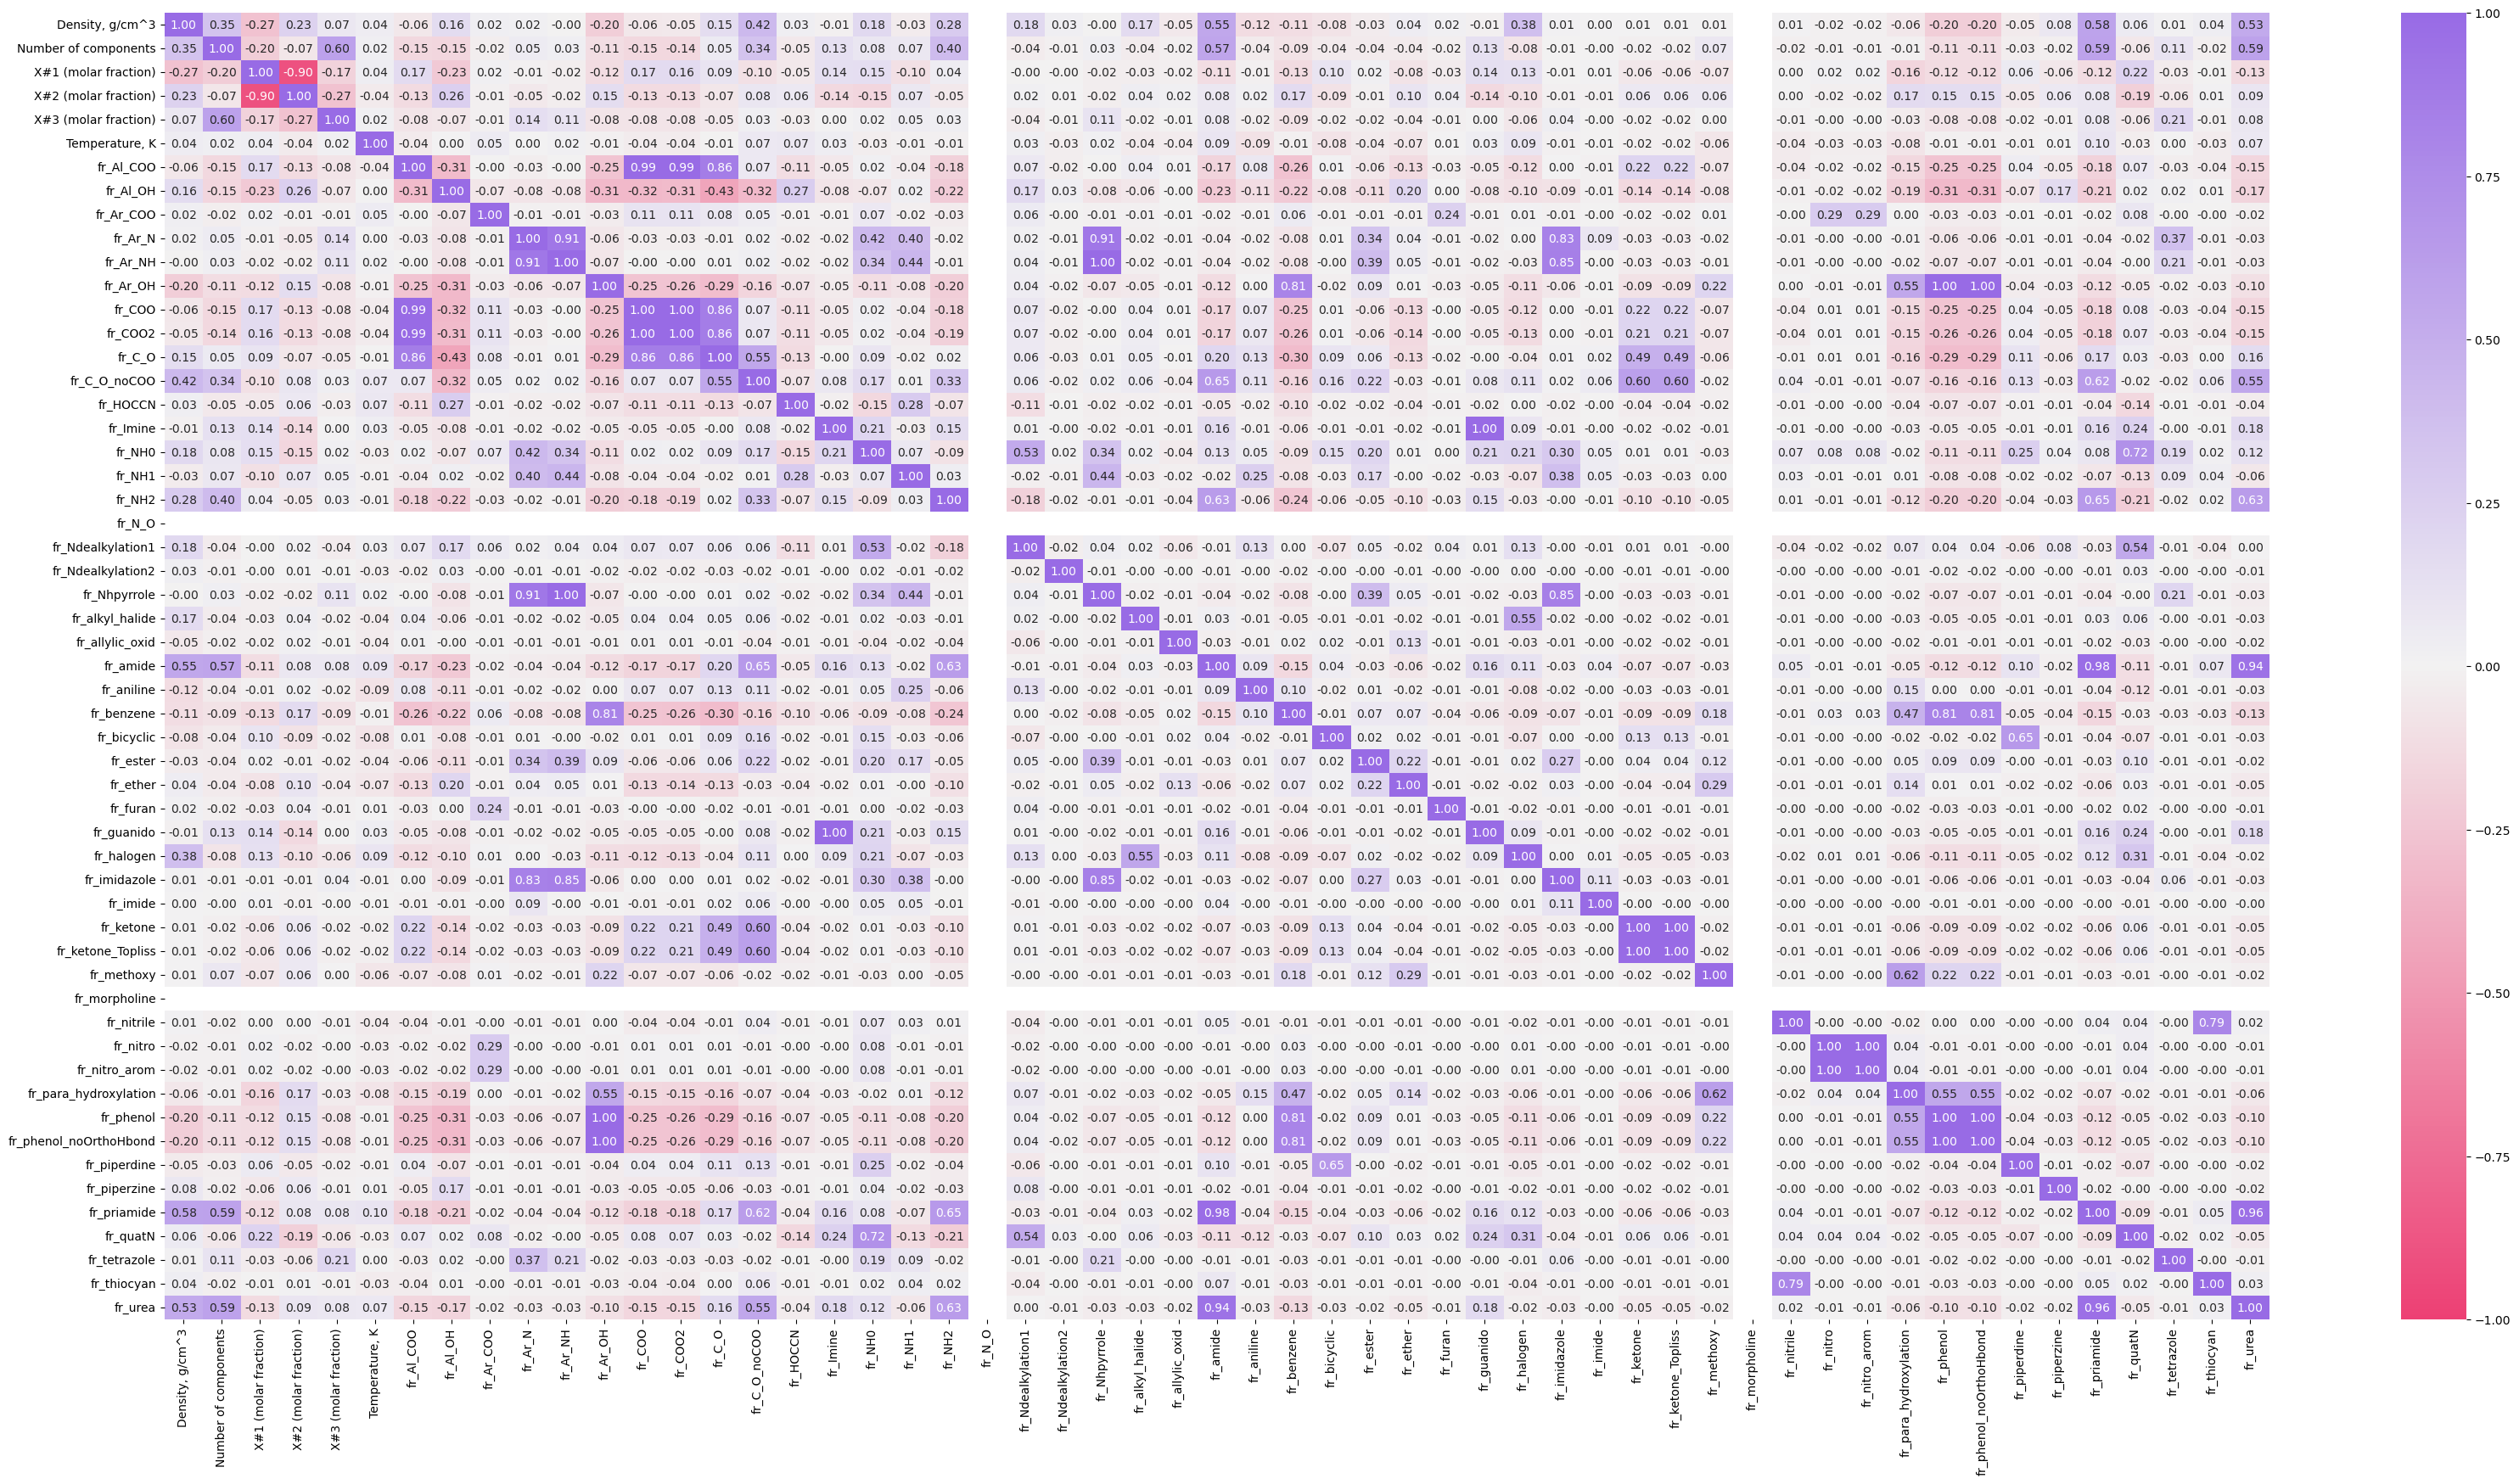

In [36]:
# Корреляции и тепловая диаграмма
#mask = np.triu(np.ones_like(new_density_df_str.corr(), dtype=bool)) #создаем маску для выделения верхнего треугольника массива
cmap = sns.diverging_palette(0, 277, s=80, l=55, n=9, as_cmap=True) #создание палитры для корреляционного графика
plt.figure(figsize=(40, 20)) #создание графика и определение его размеров
plot = sns.heatmap(new_density_df_str.corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, center= 0, cmap=cmap, linewidth=0.0005) 
#annot=True - вывод коэффициентов корреляции, fmt - число знаков после запятой, v - пределы, cmap - палитра, linewidth - толщина шрифта

Между некоторыми группами наблюдаются выскоие корреляции, поэтому оставим только некоторые

### 5.3. Тепловые диаграммы для финальной таблицы
'fr_Al_COO','fr_Al_OH','fr_Ar_COO','fr_Ar_N','fr_Ar_OH',
                                     'fr_aniline','fr_halogen', 'fr_urea'

In [37]:
#Таблица с финальными дескрипторами
density_df_MO = density_df[['Component#1', 'Component#2', 'Component#3', 'X#1 (molar fraction)', 'X#2 (molar fraction)', 'X#3 (molar fraction)','I', 'II', 'III', 'IV', 'V', 
                                     'Temperature, K', 'Density, g/cm^3','Reference (DOI)','isomer_smiles#1','isomer_smiles#2','isomer_smiles#3',
                                     'InertialShapeFactor',
                                     'SpherocityIndex','VdWVolume, A^3#1','VdWVolume, A^3#2','VdWVolume, A^3#3',
                                     'NumHeteroatoms','RingCount'] + FP_list]
density_df_MO

,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),I,II,III,IV,...,FP246,FP247,FP248,FP249,FP250,FP251,FP252,FP253,FP254,FP255
0,zinc chloride,1-Butyl-3-methylimidazolium chloride,NaN,0.50,0.50,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1-Ethyl-3-methylimidazolium chloride,"1,2,4-TRIAZOLE",NaN,0.50,0.50,0.0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,1-Ethyl-3-methylimidazolium chloride,1H-Benzotriazole,NaN,0.50,0.50,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1-Ethyl-3-methylimidazolium chloride,1H-Tetrazole,NaN,0.50,0.50,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1-Ethyl-3-methylimidazolium chloride,BENZIMIDAZOLE,NaN,0.50,0.50,0.0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4161,Butyramide,ALUMINUM CHLORIDE,NaN,0.37,0.63,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4162,Butyramide,ALUMINUM CHLORIDE,NaN,0.37,0.63,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4163,Butyramide,ALUMINUM CHLORIDE,NaN,0.37,0.63,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4164,Butyramide,ALUMINUM CHLORIDE,NaN,0.37,0.63,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Посмотрим на корреляции в итоговой таблице

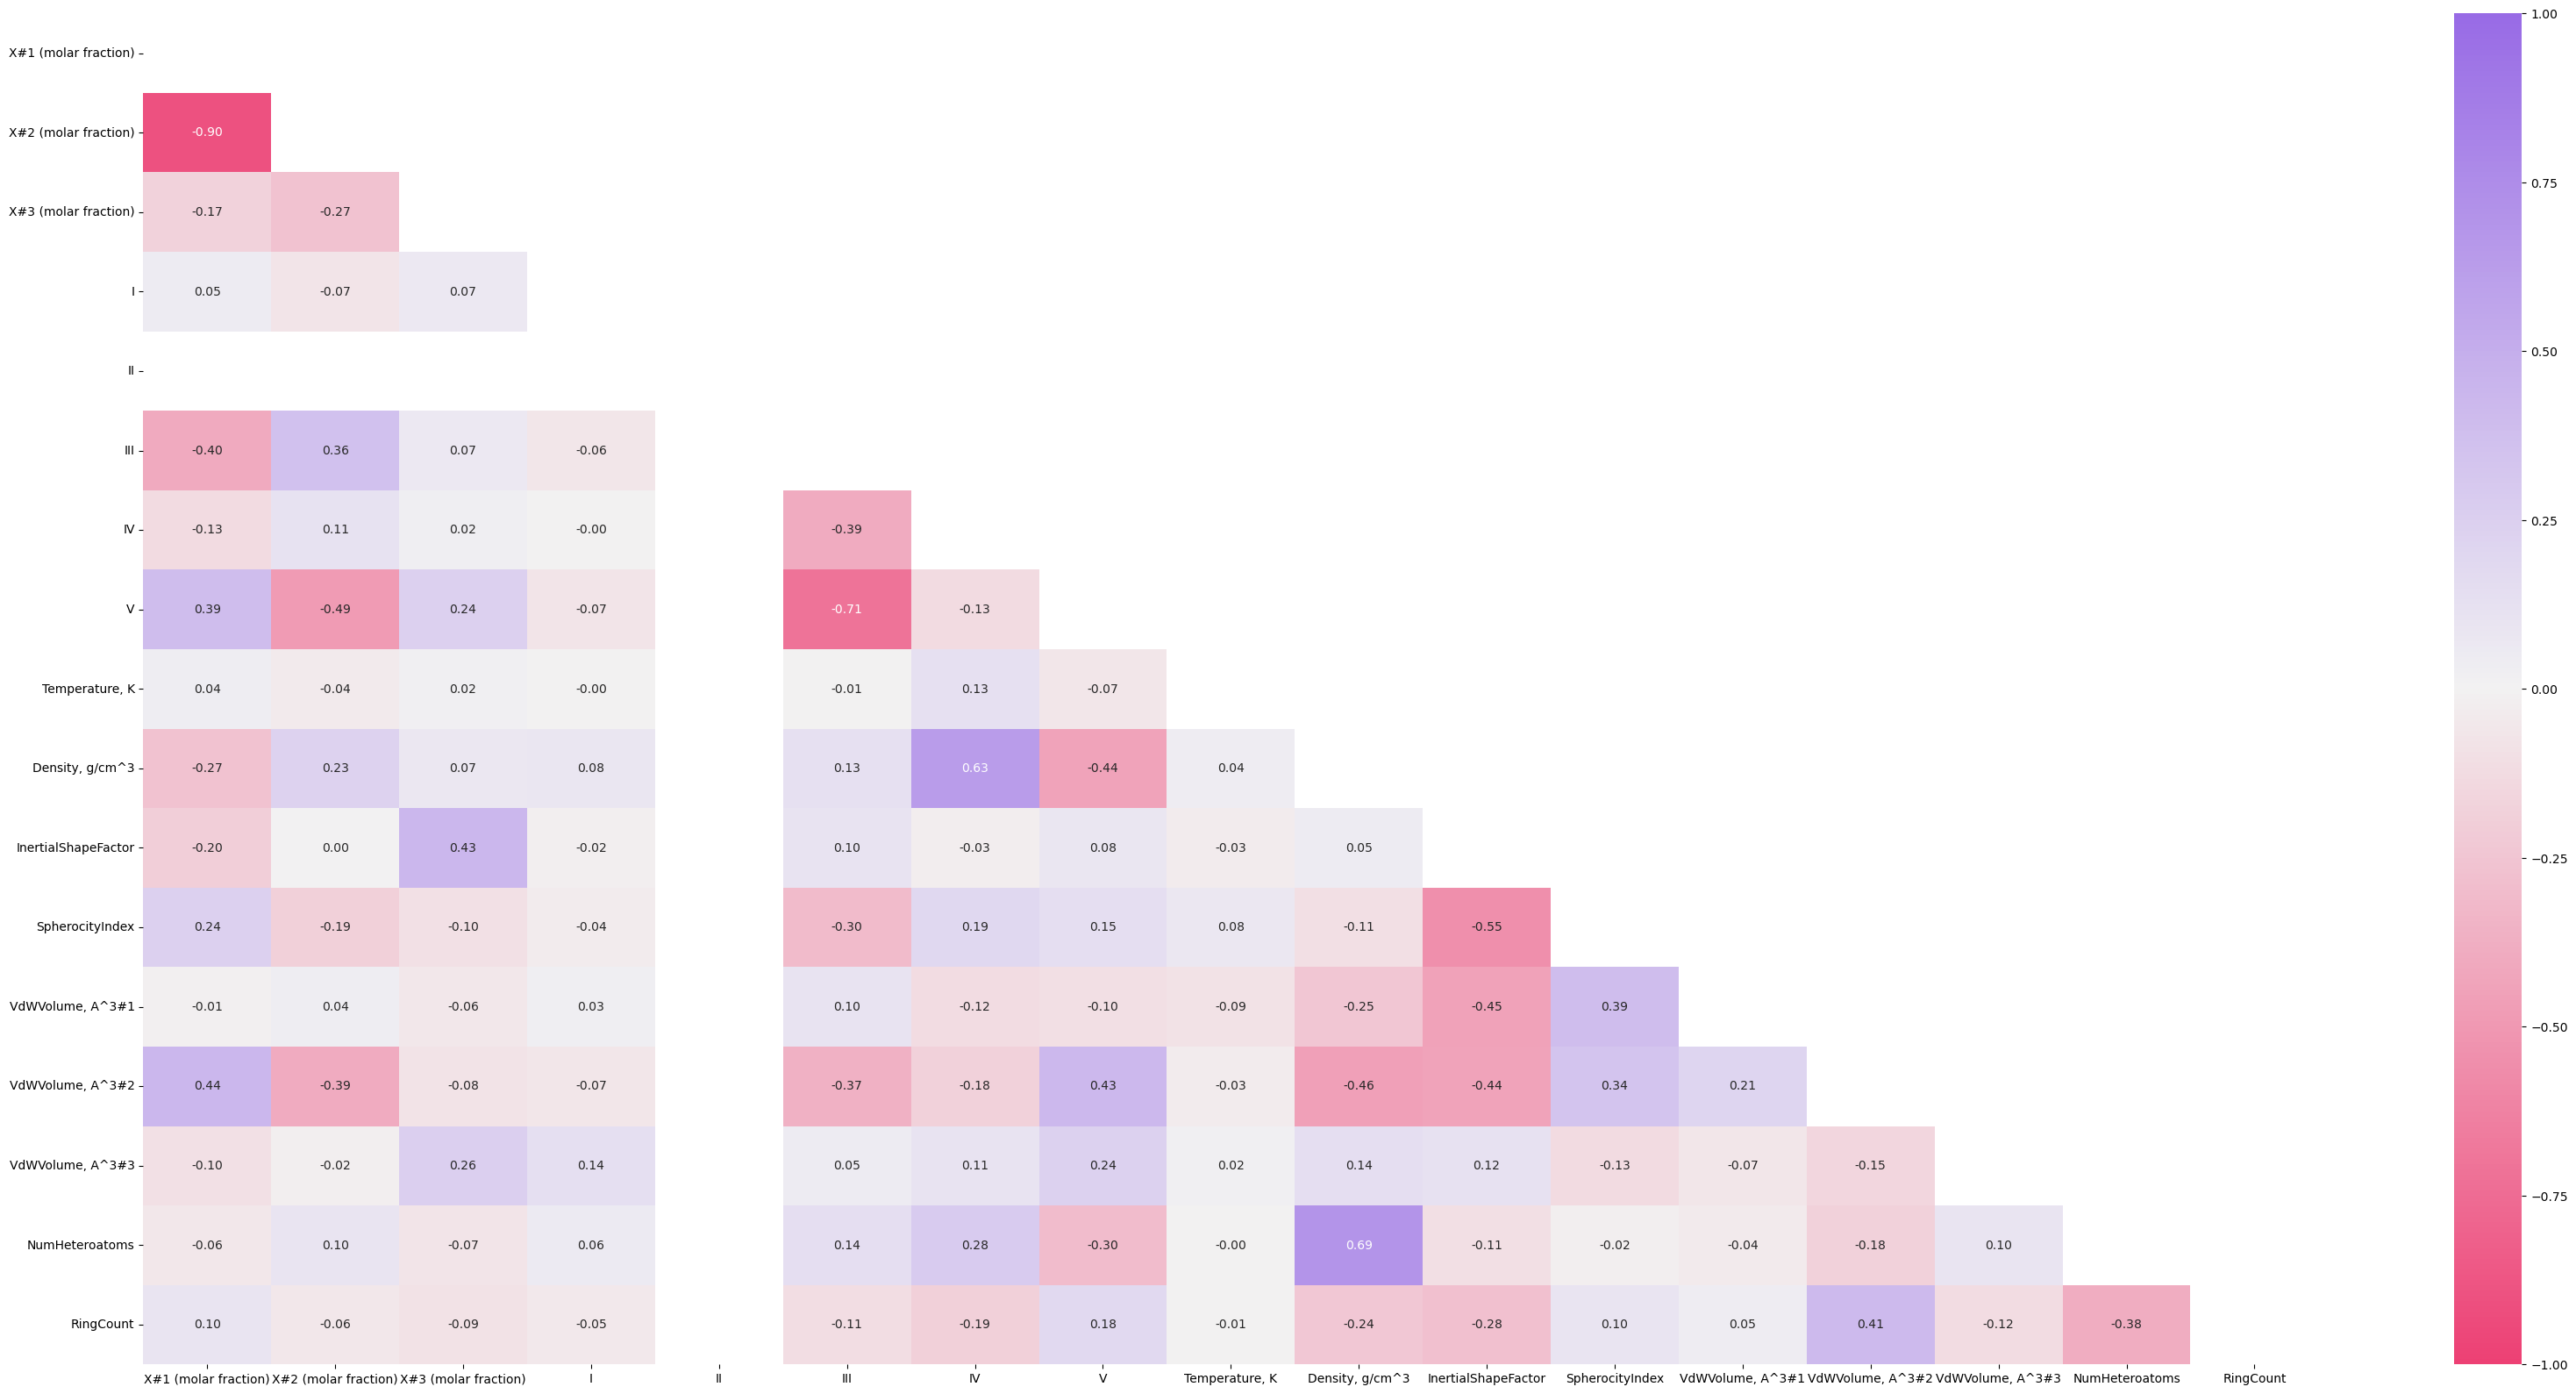

In [38]:
# Корреляции и тепловая диаграмма
mask = np.triu(np.ones_like(density_df_MO.corr(), dtype=bool)) #создаем маску для выделения верхнего треугольника массива
cmap = sns.diverging_palette(0, 277, s=80, l=55, n=9, as_cmap=True) #создание палитры для корреляционного графика
plt.figure(figsize=(40, 20)) #создание графика и определение его размеров
plot = sns.heatmap(density_df_MO.corr(), annot=True, fmt=".2f", mask = mask, vmin=-1, vmax=1, center= 0, cmap=cmap, linewidth=0.0005) 
#annot=True - вывод коэффициентов корреляции, fmt - число знаков после запятой, v - пределы, cmap - палитра, linewidth - толщина шрифта
plt.savefig('corr.png')

### 5.4. Графики для дескрипторов, наиболее коррелирующих с плотностью

C:\Users\lera-\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


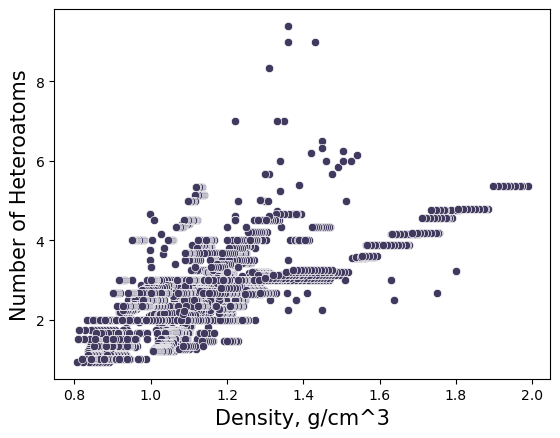

In [39]:
ax = sns.scatterplot(density_df_MO['Density, g/cm^3'], density_df_MO['NumHeteroatoms'], color = colors[0])
ax.set_xlabel('Density, g/cm^3', fontsize = 15)
ax.set_ylabel('Number of Heteroatoms', fontsize = 15)
plt.show()

In [40]:
#ax = sns.scatterplot(density_df_MO['Density, g/cm^3'], density_df_MO['fr_urea'], color = colors[3])
#ax.set_xlabel('Density, g/cm^3', fontsize = 15)
#ax.set_ylabel('Number of urea groups', fontsize = 15)
#plt.show()

C:\Users\lera-\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\lera-\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\lera-\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


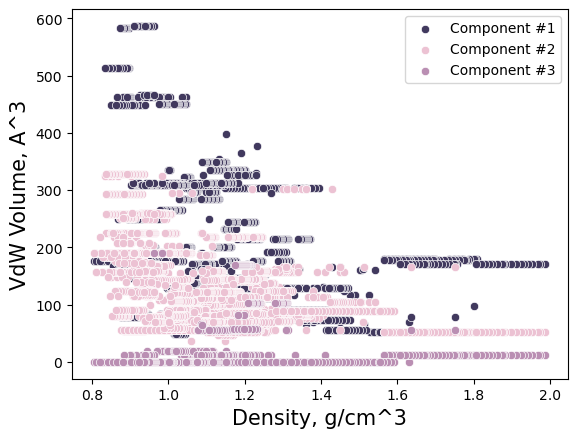

In [41]:
ax = sns.scatterplot(density_df_MO['Density, g/cm^3'], density_df_MO['VdWVolume, A^3#1'], color = colors[0], legend='auto')
ax = sns.scatterplot(density_df_MO['Density, g/cm^3'], density_df_MO['VdWVolume, A^3#2'], color = colors[2], legend='auto')
ax = sns.scatterplot(density_df_MO['Density, g/cm^3'], density_df_MO['VdWVolume, A^3#3'], color = colors[3], legend='auto')
ax.set_xlabel('Density, g/cm^3', fontsize = 15)
ax.set_ylabel('VdW Volume, A^3', fontsize = 15)
ax.legend(['Component #1', 'Component #2', 'Component #3'])
plt.show()

## 6. Добавление номеров компонентов
Для машинного обучения на системах, состоящих из нескольких веществ необходимо, чтобы в тестовую и тренировочную выборку входили разные системы

In [42]:
#Таблица с номерами по компонентам
density_df_MO['Component#3'] = density_df_MO['Component#3'].replace(np.nan, 0)
df_comp_ind = density_df_MO[['Component#1', 'Component#2', 'Component#3', 'Density, g/cm^3']]
df_comp_ind = df_comp_ind[['Component#1', 'Component#2', 'Component#3', 'Density, g/cm^3']].groupby(['Component#1', 'Component#2', 'Component#3']).agg('count')
df_comp_ind.reset_index(level = [0, 1, 2], inplace = True)
df_comp_ind

C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\4102558545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  density_df_MO['Component#3'] = density_df_MO['Component#3'].replace(np.nan, 0)


,Component#1,Component#2,Component#3,"Density, g/cm^3"
0,(+)-L-Tartaric acid,D-Glc,0,1
1,"1,3-diaminopropane",ETHYLENE GLYCOL,0,114
2,"1,3-dimethyl-2-imidazolinone",zincchloride,0,6
3,1-Butyl-3-methylimidazolium chloride,ETHYLENE GLYCOL,0,2
4,1-Butyl-3-methylimidazolium chloride,zincchloride,0,2
...,...,...,...,...
416,zinc chloride,1-Butyl-3-methylimidazolium chloride,0,1
417,zinc chloride,1-Butyl-3-methylimidazolium chloride,acetamide,2
418,zinc chloride,ETHYLENE GLYCOL,0,1
419,zinc chloride,acetamide,0,1


In [43]:
# Добавим в датафрейм столбик с индексом сисетмы
density_df_MO['ind_syst'] = 0
for i in density_df_MO.index:
  for j in df_comp_ind.index:
    if (density_df_MO.loc[i, 'Component#1'] == df_comp_ind.loc[j,'Component#1']) & (density_df_MO.loc[i,'Component#2'] == df_comp_ind.loc[j,'Component#2']) & (density_df_MO.loc[i,'Component#3'] == df_comp_ind.loc[j,'Component#3']):
      density_df_MO.loc[i,'ind_syst'] = j

density_df_MO


C:\Users\lera-\AppData\Local\Temp\ipykernel_16732\1253591331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  density_df_MO['ind_syst'] = 0


,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),I,II,III,IV,...,FP247,FP248,FP249,FP250,FP251,FP252,FP253,FP254,FP255,ind_syst
0,zinc chloride,1-Butyl-3-methylimidazolium chloride,0,0.50,0.50,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,416
1,1-Ethyl-3-methylimidazolium chloride,"1,2,4-TRIAZOLE",0,0.50,0.50,0.0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,6
2,1-Ethyl-3-methylimidazolium chloride,1H-Benzotriazole,0,0.50,0.50,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,7
3,1-Ethyl-3-methylimidazolium chloride,1H-Tetrazole,0,0.50,0.50,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,8
4,1-Ethyl-3-methylimidazolium chloride,BENZIMIDAZOLE,0,0.50,0.50,0.0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4161,Butyramide,ALUMINUM CHLORIDE,0,0.37,0.63,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,40
4162,Butyramide,ALUMINUM CHLORIDE,0,0.37,0.63,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,40
4163,Butyramide,ALUMINUM CHLORIDE,0,0.37,0.63,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,40
4164,Butyramide,ALUMINUM CHLORIDE,0,0.37,0.63,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,40


In [44]:
#Сохранение файла
density_df_MO.to_excel('density_df_MO.xlsx')

## Общие выводы по работе с данными:
Данные были собраны из литературных статей по данный тематике, всего около 4500 строк. Журналы были выбраны с высоким импакт-фактором, данные в основном были полные, то есть содержали значение плотности, названия компонентов, их мольных долей, а также температуры, при которой проводилось исследование. Самой большой проблемой была несбалансированность данных, так как ввиду непопулярности I и IV типы не были почти исследованы учеными. Чтобы сбалансировать данные для дальнейшего машинного обучения были попробованы оверсэмплинг и примение весов. Второй метод оказался более удачным, поэтому дальнейшие исследования проводились с ним. 

Что касается дескрипторов, то они были получены с помощью библиотеки RDKit или с помощью подстчета по формулам, приведенным в литературных работах, удалось посчитать дескрипторы для всех используемых веществ

Обработанные и проанализированные данные использовались для построения моделей машинного обучения
